# Earth on AWS

import Tag from '@site/src/components/Tag'

Fused interfaces <Tag color="#3399ff">Earth on AWS</Tag> through the Python `pystac_client` library. This example shows how to load data from [AWS data catalog](https://aws.amazon.com/earth/) within your Fused UDFs.


In [ ]:
# !pip install fused boto3 odc-stac xarray-spatial 'odc-stac[botocore]' pystac-client -q

## Example 1: Digital Elevation Model

In [ ]:
import fused


@fused.udf
def udf(bbox: fused.types.TileGDF):

    import odc.stac
    import pystac_client
    from pystac.extensions.eo import EOExtension as eo

    utils = fused.load(
        "https://github.com/fusedio/udfs/tree/f928ee1/public/common/"
    ).utils

    odc.stac.configure_s3_access(aws_unsigned=True)
    catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

    items = catalog.search(
        collections=["cop-dem-glo-30"],
        bbox=bbox.total_bounds,
    ).item_collection()
    print(items[0].assets.keys())
    print(f"Returned {len(items)} Items")
    resolution = int(20 * 2 ** (13 - bbox.z[0]))

    ds = odc.stac.load(
        items,
        crs="EPSG:3857",
        bands=["data"],
        resolution=resolution,
        bbox=bbox.total_bounds,
    ).astype(float)
    arr = ds["data"].max(dim="time")
    return utils.arr_to_plasma(arr.values, min_max=(0, 500), reverse=False)


arr = fused.run(udf=udf, x=557, y=372, z=10, engine="local")
arr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the axes to match image format
image_array = np.transpose(arr, (1, 2, 0))

# Display the image
plt.imshow(image_array)
plt.axis("off")  # Optional: turn off axis
plt.show()

## Example 2: Landsat

Note: might require AWS credentials to be accessible to boto3. 

https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html

In [1]:
import fused


@fused.udf
def udf(
    bbox: fused.types.TileGDF,
    time_of_interest="2023-09-01/2023-10-30",
    red_band="red",
    nir_band="nir08",
    collection="landsat-c2-l2",
):

    import odc.stac
    import pystac_client

    utils = fused.load(
        "https://github.com/fusedio/udfs/tree/f928ee1/public/common/"
    ).utils
    odc.stac.configure_s3_access(requester_pays=True)
    catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    items = catalog.search(
        collections=[collection],
        bbox=bbox.total_bounds,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
    ).item_collection()

    print(f"Returned {len(items)} Items")
    resolution = int(5 * 2 ** (15 - bbox.z[0]))
    print(f"{resolution=}")
    ds = odc.stac.load(
        items,
        crs="EPSG:3857",
        bands=[nir_band, red_band],
        resolution=resolution,
        bbox=bbox.total_bounds,
    ).astype(float)
    ndvi = (ds[nir_band] - ds[red_band]) / (ds[nir_band] + ds[red_band])
    arr = ndvi.max(dim="time")
    return utils.arr_to_plasma(arr.values, min_max=(0, 0.5))


arr = fused.run(udf=udf, x=557, y=372, z=10, engine="local")
arr

Returned 12 Items
resolution=160
(12, 245, 246)


array([[[181, 173, 192, ..., 147, 177, 170],
        [176, 158, 190, ..., 158, 169, 176],
        [160, 158, 178, ..., 137, 153, 146],
        ...,
        [184, 181, 177, ..., 180, 158, 140],
        [186, 181, 192, ..., 163, 174, 164],
        [181, 180, 192, ..., 143, 151, 174]],

       [[ 46,  38,  59, ...,  16,  43,  36],
        [ 42,  25,  56, ...,  25,  35,  42],
        [ 27,  25,  44, ...,   8,  20,  15],
        ...,
        [ 50,  46,  43, ...,  45,  25,  10],
        [ 52,  46,  59, ...,  29,  39,  30],
        [ 46,  45,  59, ...,  13,  19,  39]],

       [[140, 146, 129, ..., 161, 143, 148],
        [143, 156, 131, ..., 156, 149, 143],
        [155, 156, 142, ..., 165, 159, 162],
        ...,
        [137, 140, 143, ..., 141, 156, 164],
        [135, 140, 129, ..., 153, 145, 152],
        [140, 141, 129, ..., 163, 160, 145]]], dtype=uint8)

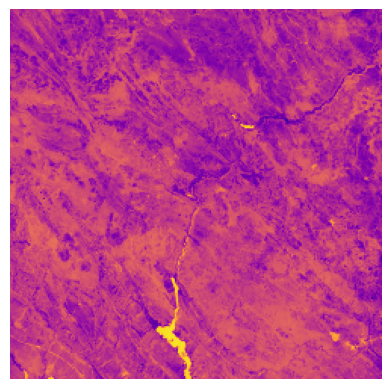

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the axes to match image format
image_array = np.transpose(arr, (1, 2, 0))

# Display the image
plt.imshow(image_array)
plt.axis("off")  # Optional: turn off axis
plt.show()